In [87]:


Patient = "P014" #"P015/P015_S01_D2024-07-06"
run = None

2025-05-07 12:58:11,111 - INFO - Using device: cpu


Intervall: 5000 - 15000


2025-05-07 12:58:11,787 - INFO - Loaded primary TDMS file: Data/P014/P014_S01_D2024-07-06.tdms
2025-05-07 12:58:12,025 - INFO - Loaded additional TDMS file: Data/P014/P014_S01_D2024-07-06_addCh.tdms
2025-05-07 12:58:12,027 - INFO - Loaded sensor log file: Data/P014/QZFM_log_file.txt
2025-05-07 12:58:12,028 - INFO - Available runs: Brustlage, Ruecken, Noise
2025-05-07 12:58:12,060 - INFO - Model loaded from MCG_segmentation/MCGSegmentator_s/checkpoints/best/model.pth


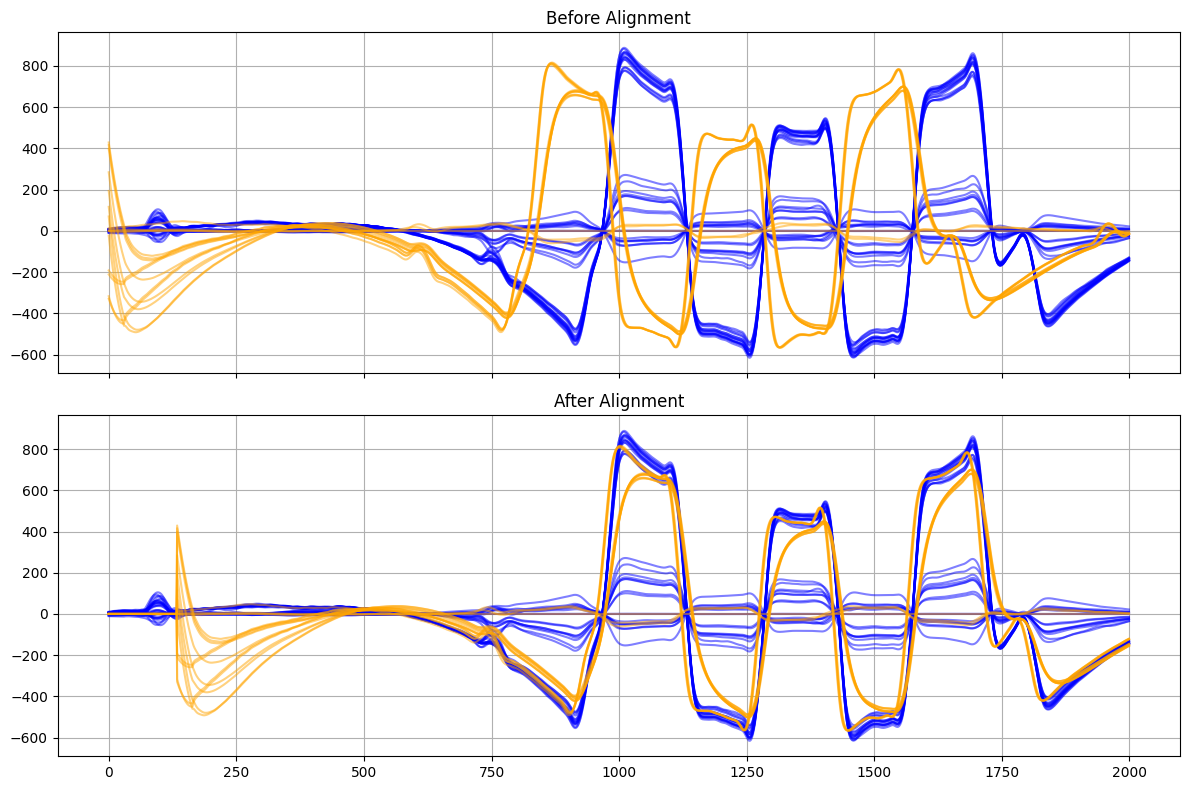

2025-05-07 12:58:13,566 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 43101, Original length: 172406 samples.


In [88]:
import importlib
import analyzer
importlib.reload(analyzer)

from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json
import numpy as np



def load_patient_data(patient: str, run: str = None):
    """
    Load patient data from the specified file.
    """

    overview = pd.read_excel("Data/overview.xlsx")
    dir = "Data/" + patient + "/"
    number = re.findall(r'\d+', dir)
    patient_number = int(number[0]) if number else None


    if overview.loc[overview["Probanten Nr."] == patient_number, "runs"].values[0].strip() == "-":
        print(f"No runs found for patient {patient_number}. Skipping...")
        return
    
    add_filename, file_name = None, None
    
    for file in os.listdir(dir):
        if file.endswith(".tdms") and file.startswith(patient):
            if run and run not in file:
                continue
            if "addCh" in file:
                add_filename = os.path.join(dir, file)
            else:
                file_name = os.path.join(dir, file)
            
    
    log_file_path = os.path.join(dir, "QZFM_log_file.txt")
    sensor_channels_to_exclude = json.loads(overview.loc[overview["Probanten Nr."] == patient_number, "Sensors to exclude"].values[0])

    
    intervall = overview.loc[overview["Probanten Nr."] == patient_number, "Intervall"].values[0]
    intervall = intervall.split(":") if isinstance(intervall, str) else intervall
    intervall_start = int(intervall[0]) if isinstance(intervall, list) else None
    intervall_end = int(intervall[1]) if isinstance(intervall, list) else None
    print(f"Intervall: {intervall_start} - {intervall_end}")

    return Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        sensor_channels_to_exclude=sensor_channels_to_exclude
    ), intervall_start, intervall_end

analysis, intervall_start, intervall_end = load_patient_data(Patient, run)

for k in analysis.key_list:
    if k in ["Brustlage", "Brust", "Bauchlage", "Bauch"]:
        key = k
        break
    
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)



## Apply ICA filtering 

In [89]:


x_data_intervall = x_data[:, :, intervall_start:intervall_end]
y_data_intervall = y_data[:, :, intervall_start:intervall_end]
z_data_intervall = z_data[:, :, intervall_start:intervall_end]
time_intervall = time[intervall_start:intervall_end]
single_run_intervall = single_run[:, intervall_start:intervall_end]


#analysis.plot4x4(z_data[:, :, 250:1250], time[250:1250], name="z_data")

x_data_filtered, _, _, _ = analysis.ICA_filter(x_data_intervall, heart_beat_score_threshold=0.70)
y_data_filtered, _, _, _ = analysis.ICA_filter(y_data_intervall, heart_beat_score_threshold=0.70)
z_data_filtered, _, _, _ = analysis.ICA_filter(z_data_intervall, heart_beat_score_threshold=0.75)








/Users/samuelfriese/Desktop/Projekte/Bachelorarbeit/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Improve Windowing

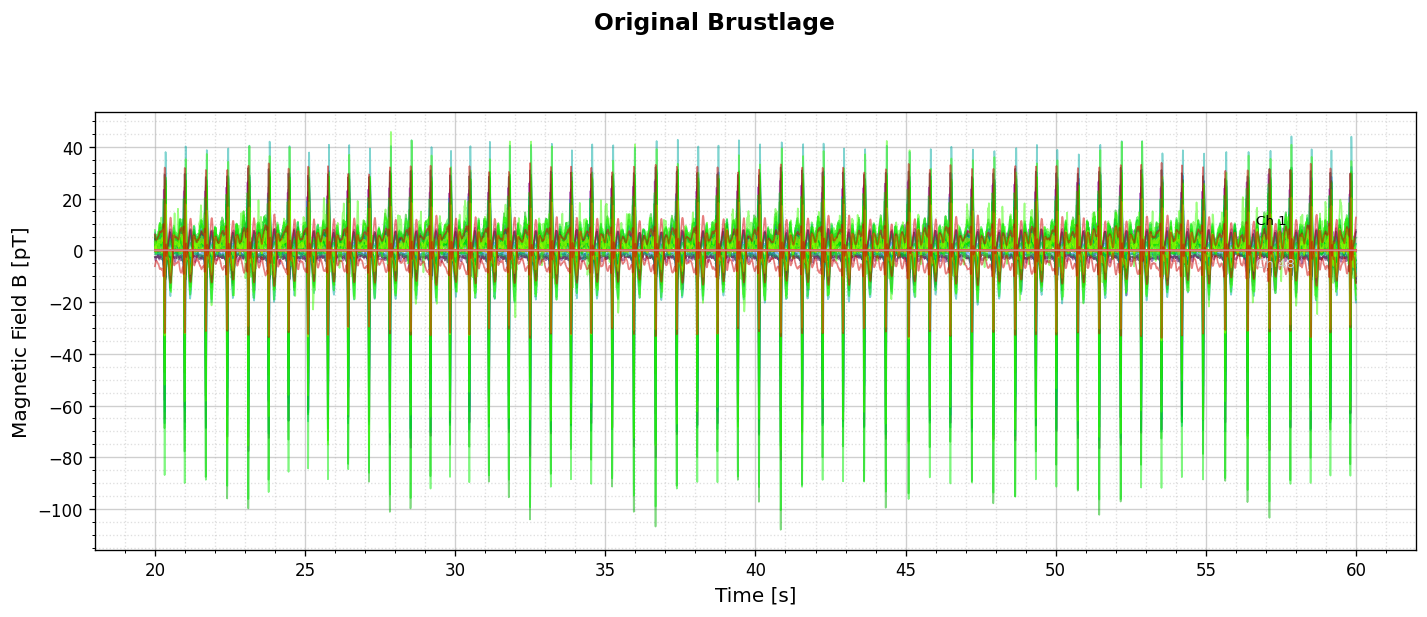

Heart Rate: 86.60 bpm
Heart Rate Variability (SDNN): 25.45 ms
Number of detected peaks: 58
Number of plausible RR intervals used: 57


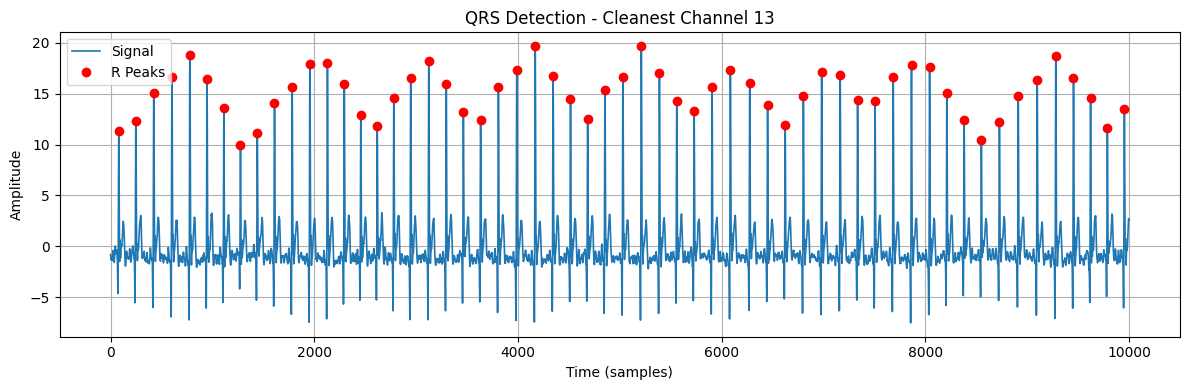

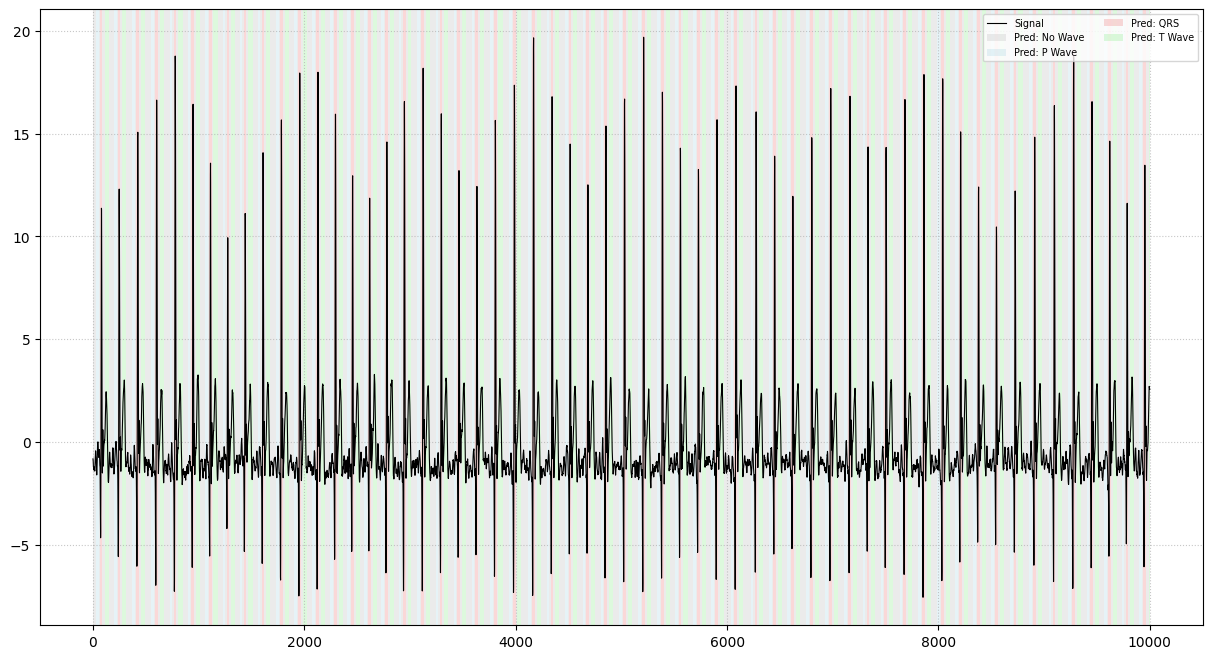

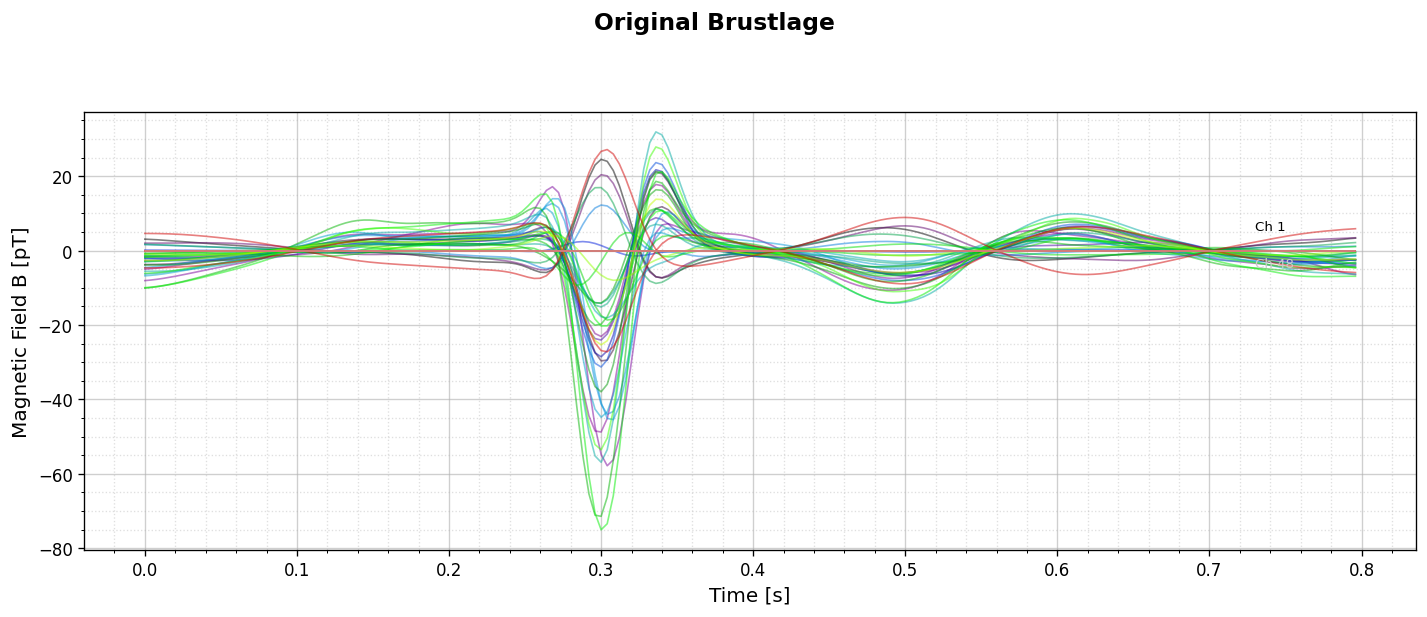

In [90]:
single_run_filtered = analysis.invert_field_directions(x_data_filtered, y_data_filtered, z_data_filtered, key, 48)




analysis.butterfly_plot(single_run_filtered, time_intervall, 48, f"Original {key}")

# use cleanest channel for peak detection
peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run_filtered, print_heart_rate=True, confidence_threshold=0.7)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(single_run_filtered[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, single_run_filtered[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(single_run_filtered[ch, :], labels[ch, :])


# window averaging
avg_channels, time_window = analysis.avg_window(single_run_filtered, peak_positions, window_left=0.3, window_right=0.5)
analysis.butterfly_plot(avg_channels, time_window, 48, f"Original {key}")



## Magentic Heart Vector

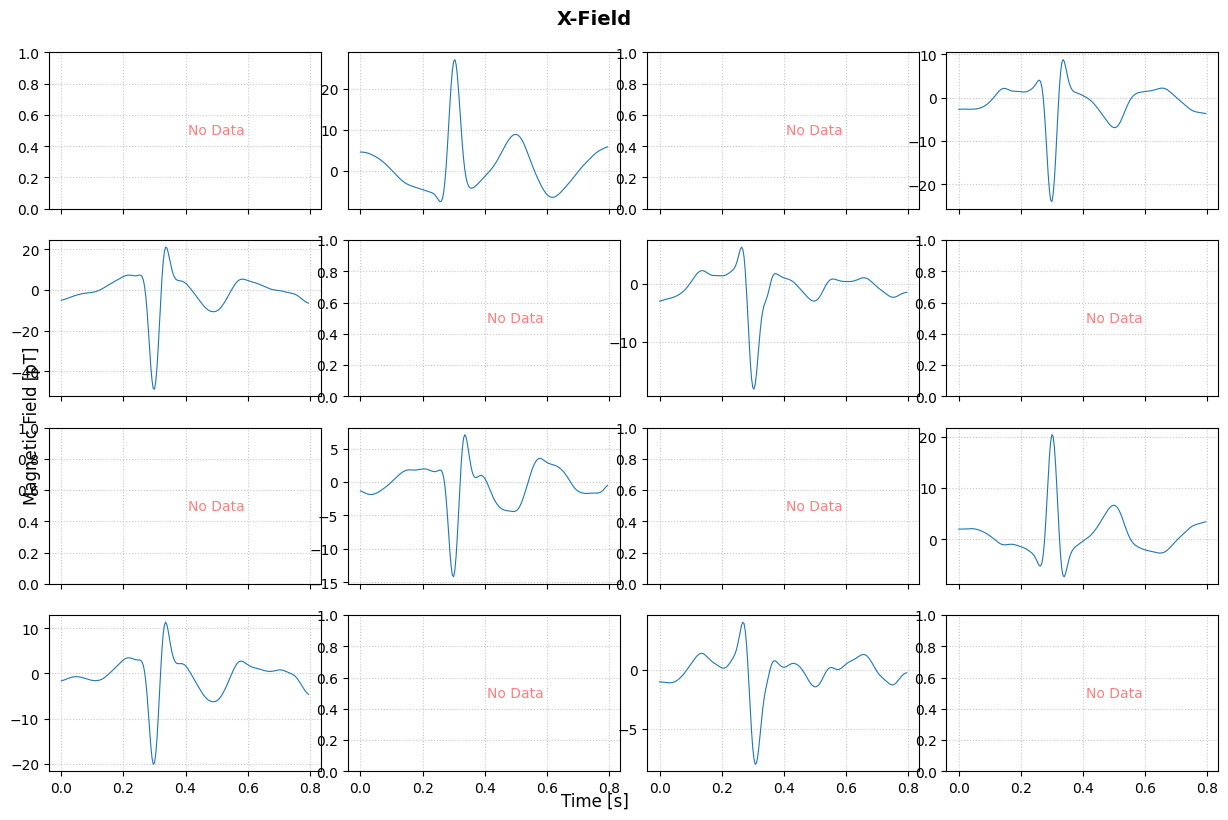

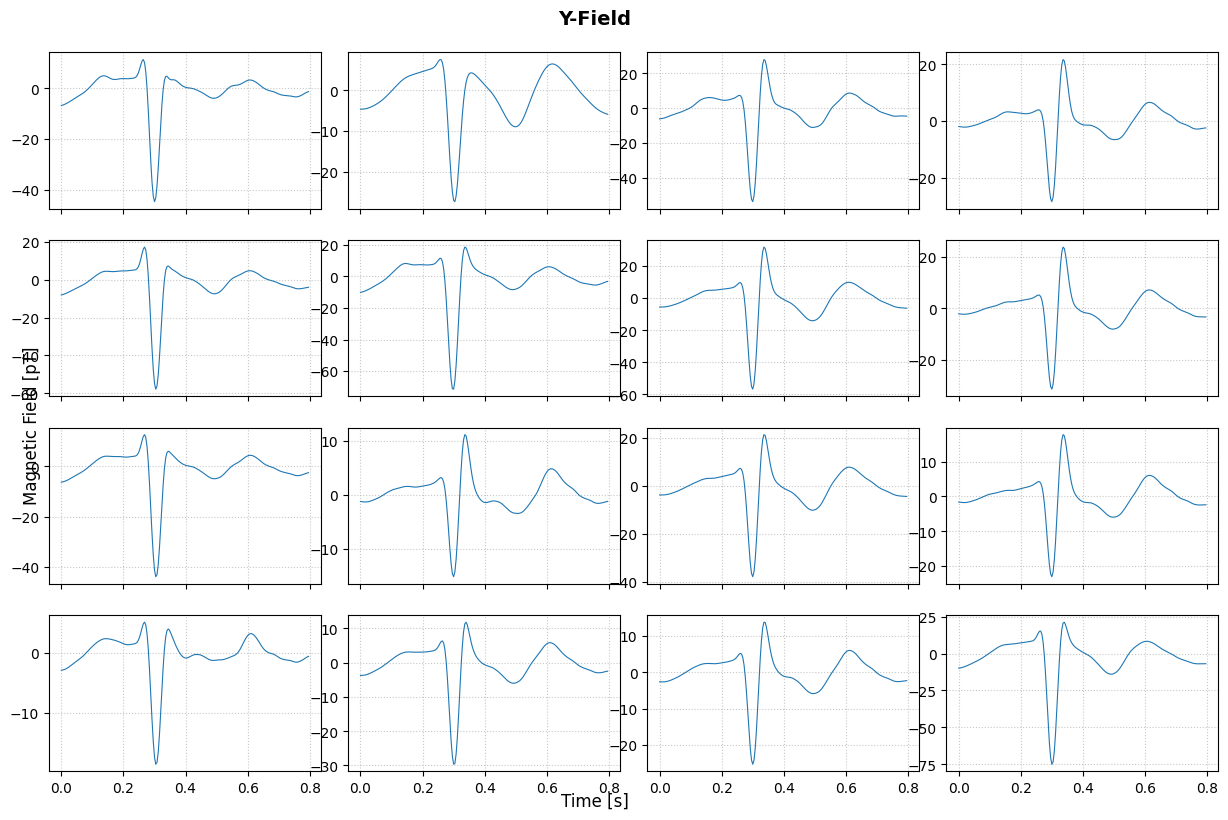

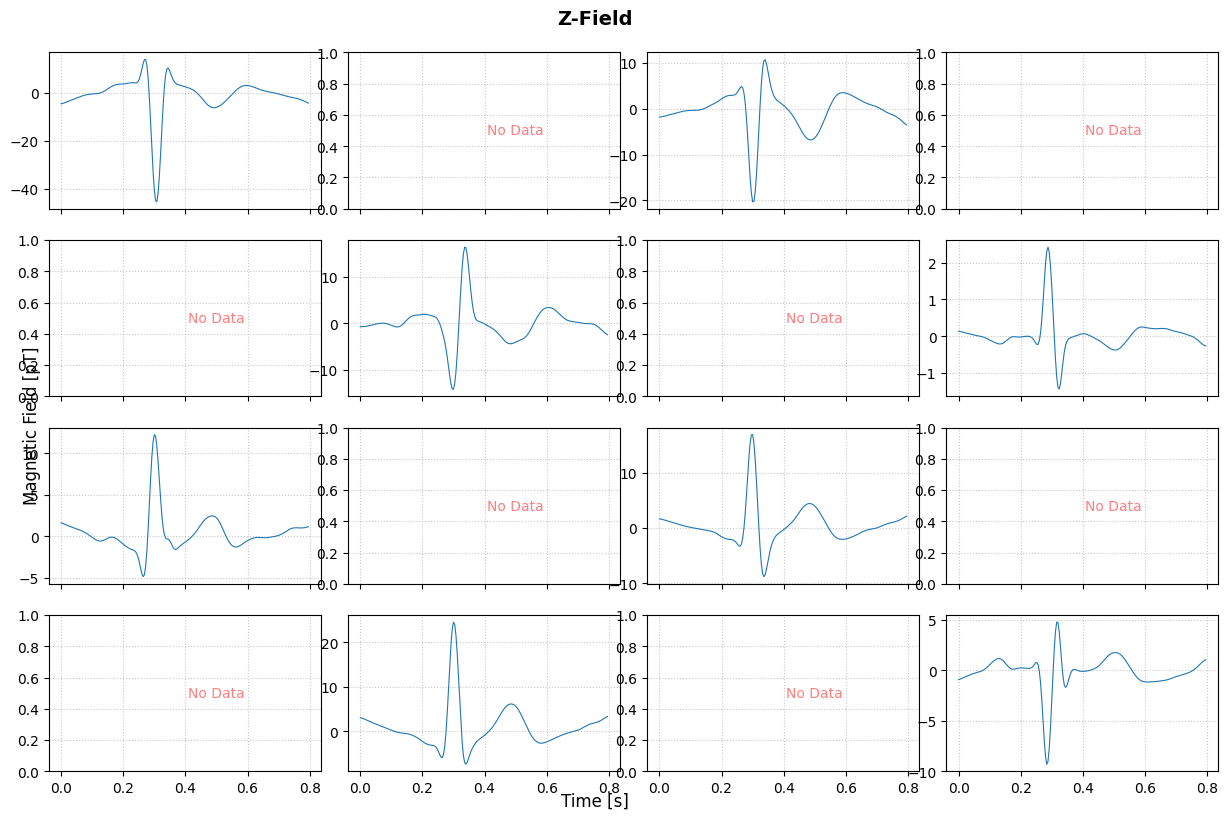

f1_data shape: (2, 200)

Channel Selection Results:
Channel   Conf        P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8082      23.00       15.50       20.50       0.5405         0.7279      
2         0.8309      13.00       15.50       25.50       0.9524         0.8673      
3         0.7984      23.50       16.00       20.00       0.5128         0.7127      
4         0.8294      14.00       16.50       25.50       0.8696         0.8415      
5         0.8082      14.00       14.00       17.00       1.0000         0.8658      
6         0.8373      12.50       13.50       32.00       0.8333         0.8361      
7         0.8448      14.00       14.00       20.00       1.0000         0.8914      
8         0.8544      14.50       16.50       24.00       0.8696         0.8590      
9         0.9364      2.50        0.00        0.00        0.2597         0.0000      
10

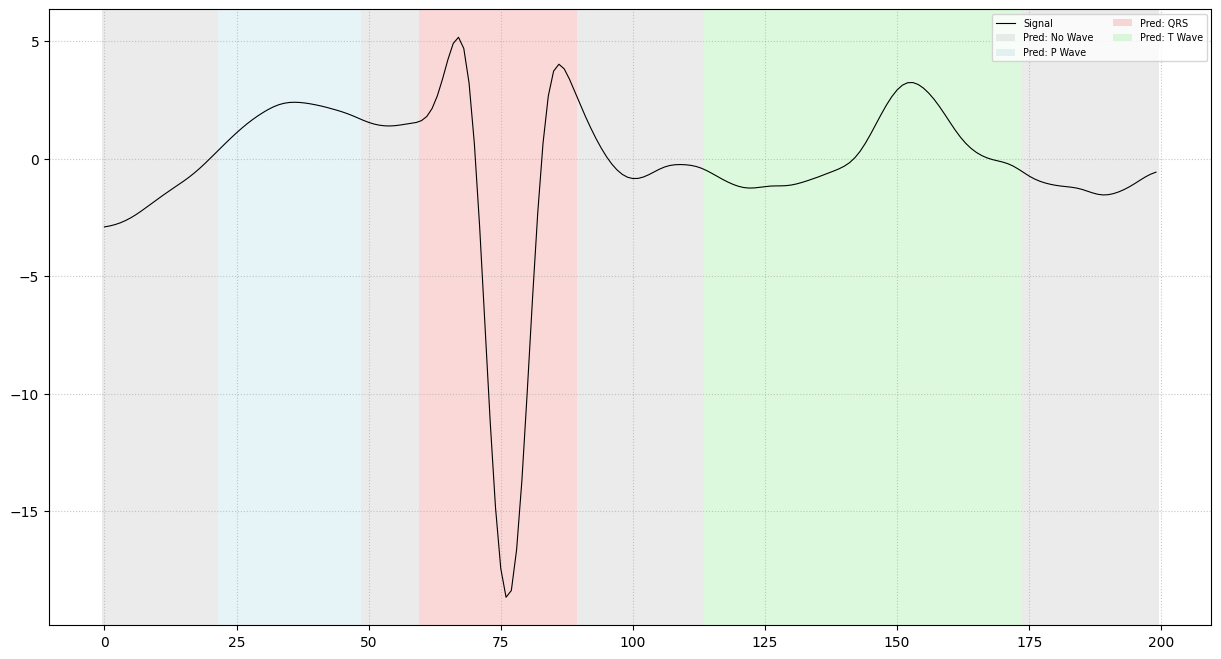

##########################################################################################
T-Wave Segment Extraction
##########################################################################################


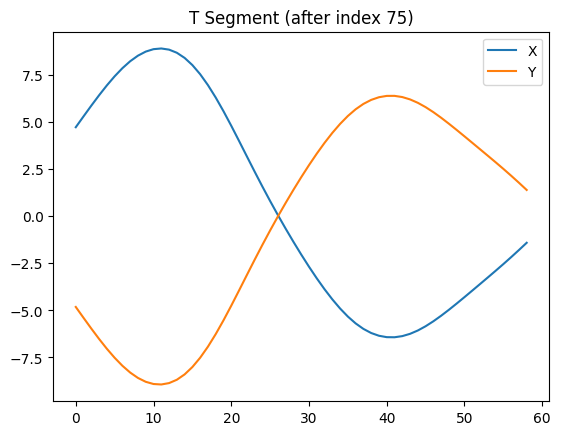

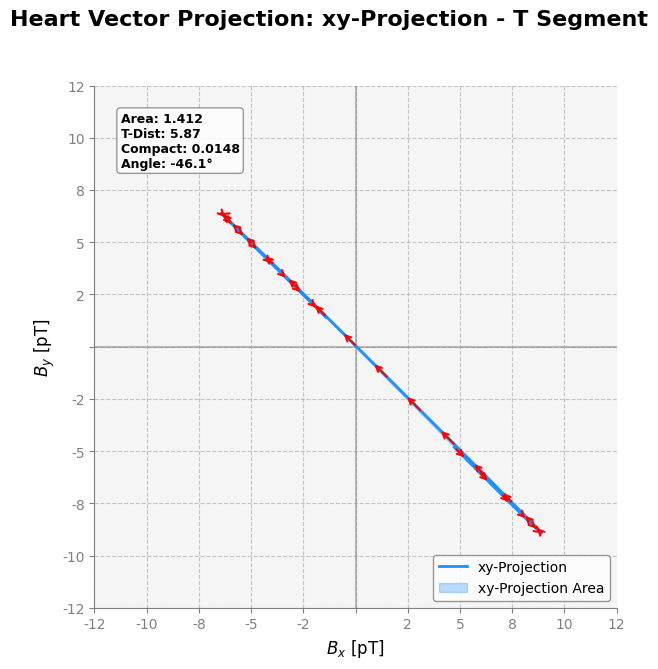

2025-05-07 13:02:20,570 - INFO - Metrics for xy-Projection: Area: 1.412
T-Dist: 5.87
Compact: 0.0148
Angle: -46.1°


##########################################################################################
QRS to T-Peak Segment with Lorentzian Fit
##########################################################################################


/var/folders/z4/s381pg0d2x72dlyfsty02y0c0000gn/T/ipykernel_37619/3314492796.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


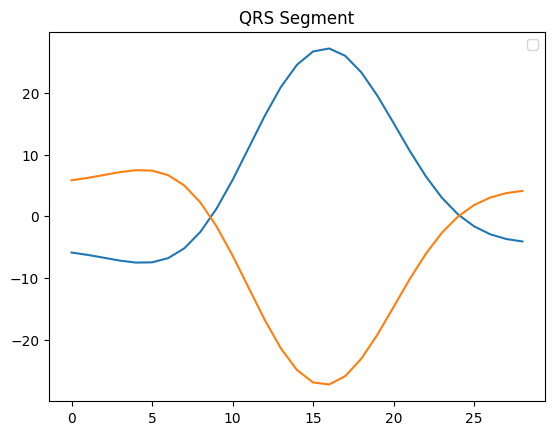

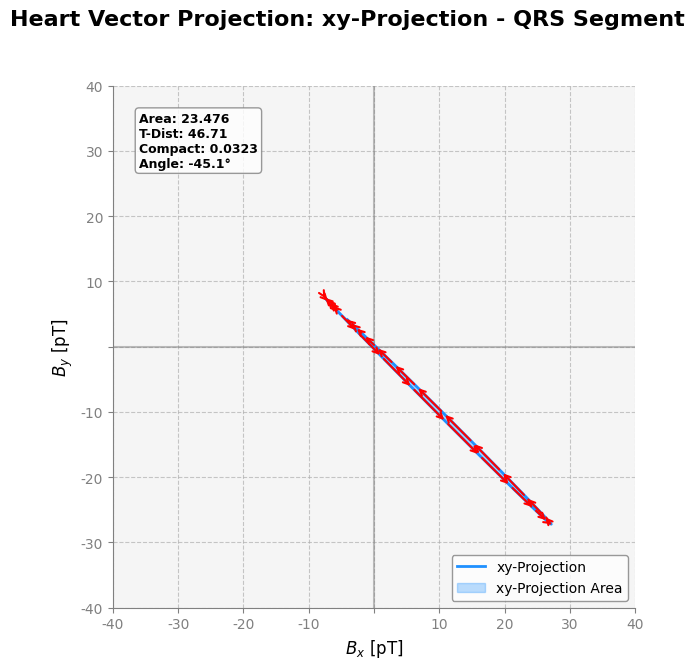

2025-05-07 13:02:20,915 - INFO - Metrics for xy-Projection: Area: 23.476
T-Dist: 46.71
Compact: 0.0323
Angle: -45.1°


In [91]:
avg_channels = np.array(avg_channels)
# --- Load averaged field data ---
x_data_window, y_data_window, z_data_window = analysis.get_field_directions(avg_channels, key)

analysis.plot_sensor_matrix(x_data_window, time_window, name="X-Field")
analysis.plot_sensor_matrix(y_data_window, time_window, name="Y-Field")
analysis.plot_sensor_matrix(z_data_window, time_window, name="Z-Field")

# Use a sample vector for projection
f1_data = np.array([x_data_window[0, 1, :], y_data_window[0, 1, :]])
print(f"f1_data shape: {f1_data.shape}")

# --- Find cleanest channel ---
best_channel, labels, confidence, _ = analysis.find_cleanest_channel(
    avg_channels, confidence_weight=0.7, plausibility_weight=0.3
)

analysis.plot_segmented_signal(avg_channels[best_channel], labels[best_channel])

print("#" * 90)
print("T-Wave Segment Extraction")
print("#" * 90)

# --- Extract T-wave segment ---
mask_t = labels[best_channel] == 3
mask_t[:110] = False  # Ignore early segment
mask_t[175:] = False  # Ignore late segment

t_segment = None
if np.any(mask_t): 
    t_indices = np.where(mask_t)[0]
    t_start, t_end = t_indices[0], t_indices[-1]
    t_segment = f1_data[:, t_start:t_end]

    plt.figure()
    plt.plot(t_segment[0], label='X')
    plt.plot(t_segment[1], label='Y')
    plt.legend()
    plt.title("T Segment (after index 75)")
    plt.show()

    analysis.plot_heart_vector_projection(t_segment[0], t_segment[1], "xy-Projection", "T Segment")
else:
    print("No T-wave segment found!")

print("#" * 90)
print("QRS to T-Peak Segment with Lorentzian Fit")
print("#" * 90)

# --- Segment from end of QRS to T-peak ---
mask_qrs = labels[best_channel] == 2
mask_qrs[:50] = False
mask_qrs[-50:] = False

if np.any(mask_qrs) and t_segment is not None:
    t_start_qrs = np.where(mask_qrs)[0][0] 
    t_end_qrs = np.where(mask_qrs)[0][-1] 
    # QRS  segment
    segment_qrs = f1_data[:, t_start_qrs:t_end_qrs]

    plt.figure()
    plt.plot(segment_qrs[0])
    plt.plot(segment_qrs[1])
    plt.title("QRS Segment")
    plt.legend()
    plt.show()

    analysis.plot_heart_vector_projection(
        segment_qrs[0], segment_qrs[1],
        "xy-Projection", "QRS Segment"
    )
else:
    print("QRS or T segment not found!")

